<a href="https://colab.research.google.com/github/iciromaco/RadiShLab/blob/master/N004_%E5%AE%9F%E9%A8%93%E7%94%A8%E3%82%B7%E3%83%AB%E3%82%A8%E3%83%83%E3%83%88%E7%94%BB%E5%83%8F%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E7%94%9F%E6%88%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N004 実験用の正規化シルエット画像データの生成

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"
# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

rInput_SilF = 'RDSamples/silhoette' # シルエット画像フォルダ(ホーム基準のパス)
rOutput_SilF = 'RDSamples/silhoetteM' # 余白調節したシルエット画像のフォルダ
rInput_SrcF = 'RDSamples/cropped' # シルエットに対する原画像のフォルダ
rOutput_SrcF = 'RDSamples/croppedM' # 余白調整シルエットに対する余白調整した原画像のフォルダ
SilImagesF = 'RDSamples/NSilImages' # 正規化したシルエット画像を保存するフォルダ

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

aInput_SilF  = "/".join([labhome,rInput_SilF])  # シルエット画像フォルダ
aOutput_SilF = "/".join([labhome,rOutput_SilF])# 余白調節したシルエット画像のフォルダ
aInput_SrcF = "/".join([labhome,rInput_SrcF])   # シルエットに対する原画像のフォルダ
aOutput_SrcF = "/".join([labhome,rOutput_SrcF]) # 余白調整シルエットに対する余白調整した原画像のフォルダ
aSilImageF = "/".join([labhome,SilImagesF]) #  正規化したシルエット画像を保存するフォルダ

## 目的
S2(N002)　あるいは　S3(N003)　のインタラクティブ前景抽出により得られたシルエット画像はマージン量がまちまちで位置が偏っていたりするので、位置とマージンを調整し、画像のほぼ中央に対象を配置し、上下左右に均等なマージンをとりたい。

- RDSamples/cropped  原画像から対象を切り出した部分画像、
- RDSamples/silhoette 部分画像のシルエット画像

を例とする。

## 重要な前提
- ファイル名を辞書式順序でならべたときに、シルエット画像とそのソース画像の順番が一致していること。

例えば、ソース画像名に固定の接頭語、接尾語をつけるという命名規則でシルエット画像にファイル名をつけているなら条件を満たす。

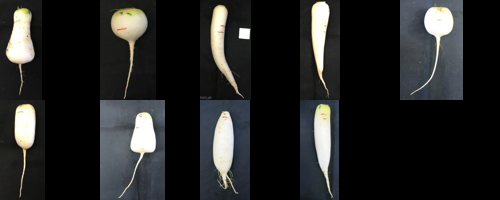

In [2]:
# 切り出した元の画像
rd.makethumbnail(aInput_SrcF)

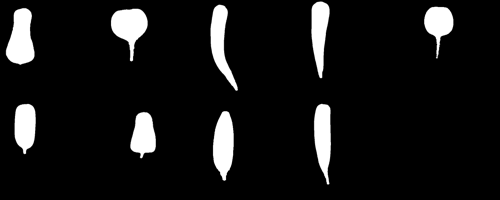

In [3]:
# シルエット画像
rd.makethumbnail(aInput_SilF)

In [4]:
# ファイル名を確認
srcfilenames = rd.collectimagepaths(aInput_SrcF)
srcfilenames

['./RDSamples/cropped\\Sil_17daruma5o03_l_Org.png',
 './RDSamples/cropped\\Sil_17heians1o04_l_Org.png',
 './RDSamples/cropped\\Sil_17horyot1o06_l_Org.png',
 './RDSamples/cropped\\Sil_17horyot2o07_l_Org.png',
 './RDSamples/cropped\\Sil_17karami1o09_l_Org.png',
 './RDSamples/cropped\\Sil_17makoto2o06_l_Org.png',
 './RDSamples/cropped\\Sil_17nezumi2o02_l_Org.png',
 './RDSamples/cropped\\Sil_17ofukur1o07_l_Org.png',
 './RDSamples/cropped\\Sil_17tukasa1o02_l_Org.png']

In [5]:
silfilenames = rd.collectimagepaths(aInput_SilF)
silfilenames

['./RDSamples/silhoette\\Sil_17daruma5o03_l.png',
 './RDSamples/silhoette\\Sil_17heians1o04_l.png',
 './RDSamples/silhoette\\Sil_17horyot1o06_l.png',
 './RDSamples/silhoette\\Sil_17horyot2o07_l.png',
 './RDSamples/silhoette\\Sil_17karami1o09_l.png',
 './RDSamples/silhoette\\Sil_17makoto2o06_l.png',
 './RDSamples/silhoette\\Sil_17nezumi2o02_l.png',
 './RDSamples/silhoette\\Sil_17ofukur1o07_l.png',
 './RDSamples/silhoette\\Sil_17tukasa1o02_l.png']

ここでは、切り出し画像（カラー）のファイル名は、**シルエット画像のファイル名＋\_Org** と名づけられているものと仮定する。

## makemargin()  余白をつける
> **rd.makemargin(img,mr=1.5,mm = 10)**

> 入力
>>   **img** 入力画像

>> パラメータ
>>   **mr** 余白量（相対指定）  
>>   **mm** 余白量（絶対指定）

> 出力
>>    **oimg**  余白調整した画像

## cutmargin()  余白の削除
> **rd.cutmargin(img,mr=1.0,mm=0,withRect=False)**

> 入力
>>   **img** 入力画像

>パラメータ
>>   **mr**,**mm**  makemargin() に渡すパラメータ  
>>   **withRect** バウンダリボックスを返り値に含めるかどうかの真理値

> 出力
>>   **oimg**  余白調整した画像  
>>   **x,y,w,h**  バウンダリ情報（もとの画像中のどこを切り出したか）
    
# 一定の余白を残したマージンカットのプログラム例

対象がほぼ中央に収まって上下左右の余白量が均一になるようにマージンを調整した画像を生成

In [6]:
imgs = rd.collectimages(aInput_SilF)       # シルエット画像のリスト
srcimgs = rd.collectimages(aInput_SrcF)  # 対応する原画像のリスト

# マージン調整のプログラム
mm = 32 # 上下左右の余白量
msimg,msrcimg = [],[]
for img,srcimg in zip(imgs,srcimgs):
    img0,x,y,w,h = rd.cutmargin(img,mm=mm,withRect=True) # マージンをつける
    h2,w2 = img0.shape[:2]
    msimg.append(img0)
    img1 = np.zeros((h2,w2,3),np.uint8)
    img1[mm:mm+h,mm:mm+w] = srcimg[y:y+h,x:x+w]
    msrcimg.append(img1)

###  上のセルを実行すると、msimg, msrcimg は、マージン調節したシルエット画像とソース画像のリストとなる。

## 結果確認

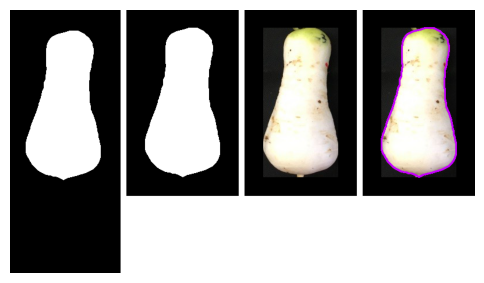

In [7]:
# 結果の表示
def resultplot(n):
    plt.figure(dpi=100)
    rd.plotimg(rd.mkparaimage([imgs[n],msimg[n],msrcimg[n],rd.draw2(msimg[n],msrcimg[n])]))
    
resultplot(0)

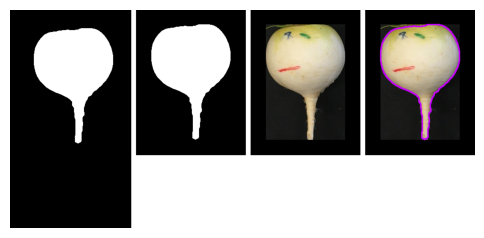

In [8]:
resultplot(1)

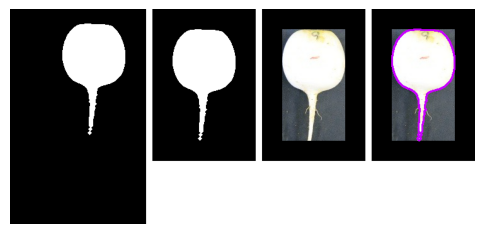

In [9]:
resultplot(4)

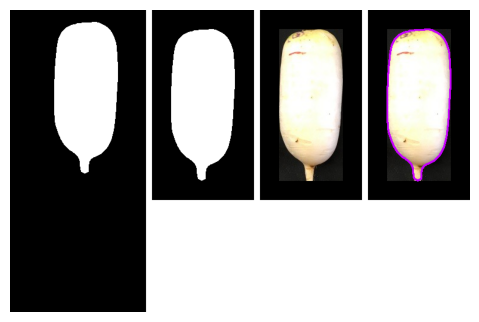

In [10]:
resultplot(5)

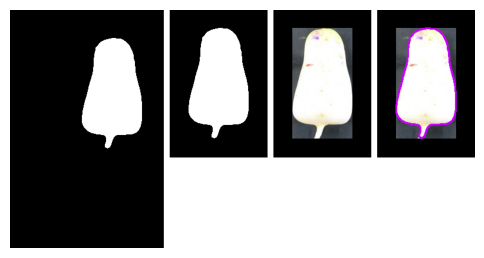

In [11]:
resultplot(6)

# 結果画像の保存

- マージンを調整したシルエット画像のファイル名は、元のファイル名の頭に "**M_**" をつける。
- シルエット画像のマージンに合わせてマージンを調整した原画像のファイル名前はシルエット画像名の末尾に"**\_Org**" をつけたファイル名とする。

In [12]:
# ファイル名
pref = '/M_'
suf = '_Org'
if not os.path.exists(aOutput_SilF):
    os.mkdir(aOutput_SilF)
if not os.path.exists(aOutput_SrcF):
    os.mkdir(aOutput_SrcF)
for img,srcimg,path in zip(msimg,msrcimg,silfilenames):
    basename = os.path.basename(path)
    name,ext = os.path.splitext(basename)
    msname = aOutput_SilF + pref + basename # マージン調整したシルエット画像のファイル名
    msrcname = aOutput_SrcF + pref +name+ suf +ext
    cv2.imwrite(msname,img)
    cv2.imwrite(msrcname,srcimg)

## 結果確認

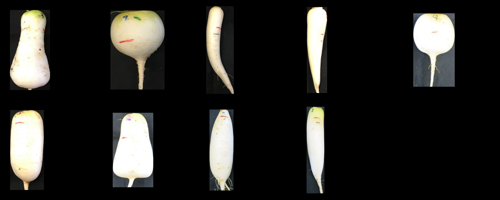

In [13]:
rd.makethumbnail(aOutput_SrcF)

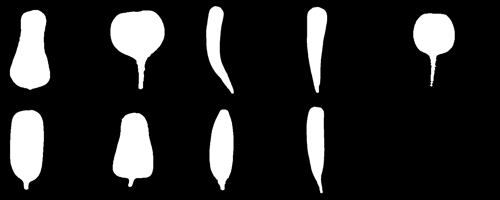

In [14]:
rd.makethumbnail(aOutput_SilF)

---

# 大きさと方向の正規化

## getNormSil() 大きさを正規化したシルエットの生成
> **rd.getNormSil(img,tiltzero=True,mr=1.5,unitSize=UNIT)**

> 入力
>>   **img** シルエット画像  

> パラメータ  
>>   **tiltzero** 傾きを正すかどうかの真理値  
>>   **mr**  　　　マージンなし画像に対するマージンあり画像のサイズ比率  
>>   **unitSize** 正規化サイズ　近似楕円の長さがこのサイズになるようにリサイズする  

> 出力  
>>   **oimg**  正規化した画像
>>     (**UNIT**は256をデフォルトとしている）
    
## makeUnitImage() 長辺の mr 倍サイズの枠の中央に対象を配置した画像を返す
> **rd.makeUnitImage(img,mr=1.5,unitSize=UNIT)**

> 入力  
>>   **img** 

> パラメータ
>>   **mr** 　　出力画像のサイズを決めるパラメータ
>>   **unitSize**　出力画像におけるオブジェクトのバウンダリの長辺の長さ

> 出力
>>   **oimg**
    
長辺が UNIT ピクセルになるよう縮小し、(mrxUNIT)x(mrxUNIT)の画像の中央に配置する。

## tiltZeroImg()  傾き補正
> **d.tiltZeroImg(img)**

> 入力
>>   **img**

> 出力
>>   **oimg**
    
近似楕円の軸方向が水平垂直となるように回転補正した画像を生成する。


In [15]:
# シルエットの正規化バッチプログラム
simgs = rd.collectimages(aOutput_SilF)       # シルエット画像のリスト
silfilenames = rd.collectimagepaths(aInput_SilF) # シルエット画像の名前のリスト

nimgs = []
if not os.path.exists(aSilImageF):
    os.mkdir(aSilImageF)
for simg, path in zip(imgs,silfilenames):
    img1 = rd.getNormSil(simg,tiltzero=True,mr=1.2,unitSize=256)
    nimgs.append(img1)
    basename = os.path.basename(path)
    name,ext = os.path.splitext(basename)
    savename = aSilImageF + '/N_' + basename
    cv2.imwrite(savename,img1)

# 結果表示のための関数
def resultplot2(n):
     # 原シルエットの輪郭線追跡
    img = imgs[n].copy()
    cnt = rd.cv2findContours34(img, 1, 2)[0][0]
    canvas0 = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    ellipse = cv2.fitEllipse(cnt) #  近似楕円を求める
    cv2.ellipse(canvas0,ellipse,(0,255,0),2) # 楕円を描画
    
    # 回転補正し大きさを正規化した画像を作る
    img1 = rd.getNormSil(img,tiltzero=True,mr=1.2,unitSize=256)
    cnt1 = rd.cv2findContours34(nimgs[n], 1, 2)[0][0]
    canvas1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    ellipse1 = cv2.fitEllipse(cnt1) #  近似楕円を求める
    cv2.ellipse(canvas1,ellipse1,(0,255,0),2) # 楕円を描画

    canvas = rd.mkparaimage([canvas1,canvas0])
    plt.figure(figsize=(6,6),dpi=75)
    rd.plotimg(canvas)


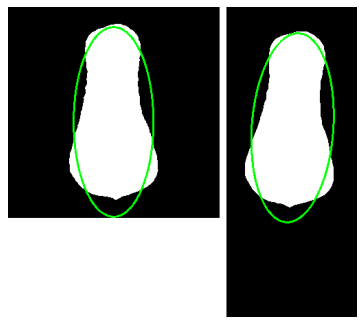

In [16]:
resultplot2(0)

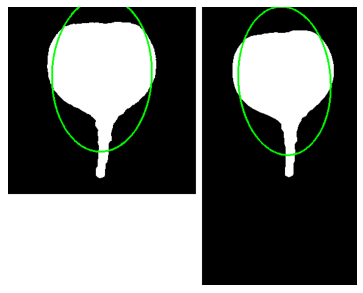

In [17]:
resultplot2(1)

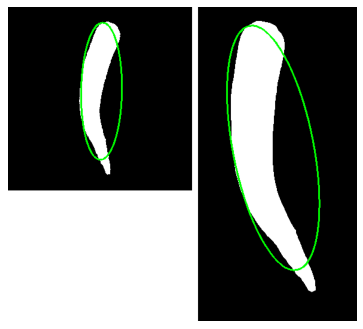

In [18]:
resultplot2(2)

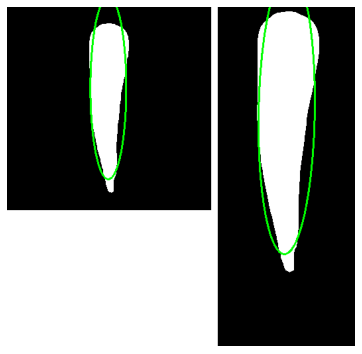

In [19]:
resultplot2(3)

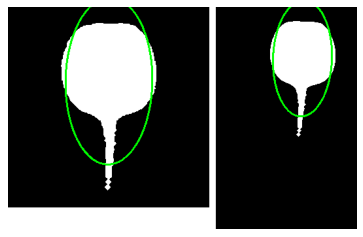

In [20]:
resultplot2(4)

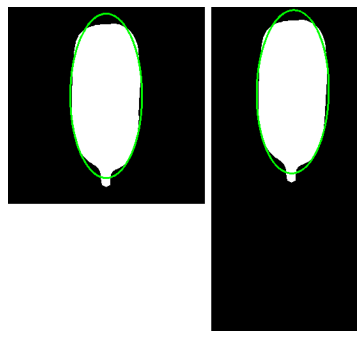

In [21]:
resultplot2(5)

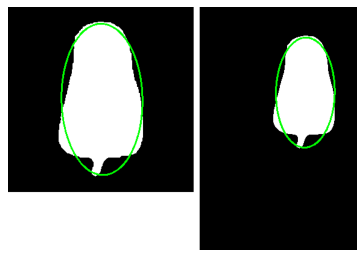

In [22]:
resultplot2(6)

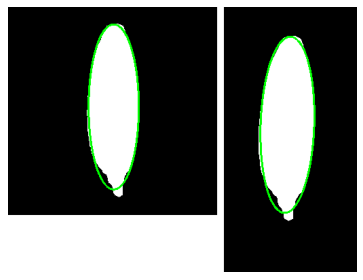

In [23]:
resultplot2(7)

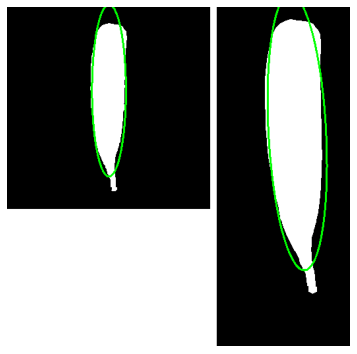

In [24]:
resultplot2(8)

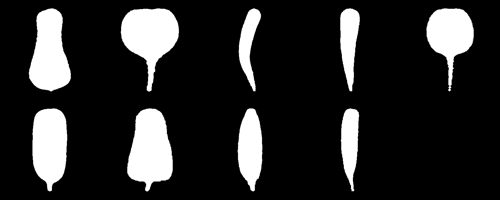

In [25]:
# Silサムネイルの表示
rd.makethumbnail(aSilImageF)

In [26]:
nimgs[0].shape

(308, 308)